In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import os
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix, mean_squared_error
from sklearn.svm import SVR
from sklearn.feature_selection import RFE
from scipy import stats
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import classification_report
%matplotlib inline

### Reading the Data

In [2]:
income = pd.read_csv("income_data.csv", sep=r'\s*,\s*', engine='python')
income.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


## Question 1
Build visualizations and plots to see how the dependent variable varies with some of the other variables, such as 'education', 'marital-status', 'occupation', etc and study other interrelationships of the variables. Use them to tell a story/stories.


### Basic EDA

In [3]:
# Generates descriptive statistics of numerical variables
income.describe()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


### Age
Possible transformation:
- Create age bins: 20_below, 21-30, 31-40, 41-50, 51-60, 60_above

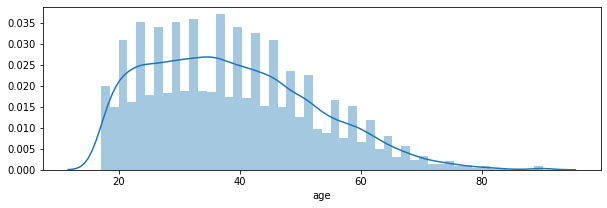

In [4]:
plt.figure(figsize=(10,3))
sns.distplot(income.age)

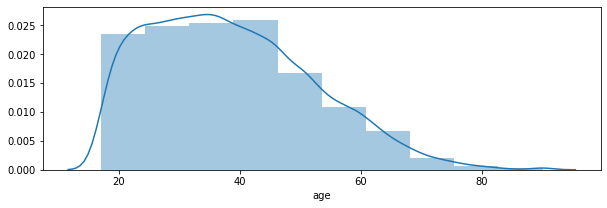

In [5]:
# Creates histogram of age with bin size of 10 years
plt.figure(figsize=(10,3))
sns.distplot(income.age, bins=10)

### Working Class
Possible combinations:
- Local-gov, Sate-govworkclass, and Federal-gov can be combined into Government_Work
- Self-emp-not-inc and Self-emp-inc can be combined into Self_Employed
- ?, Without-pay and Never-worked can be combined into Other

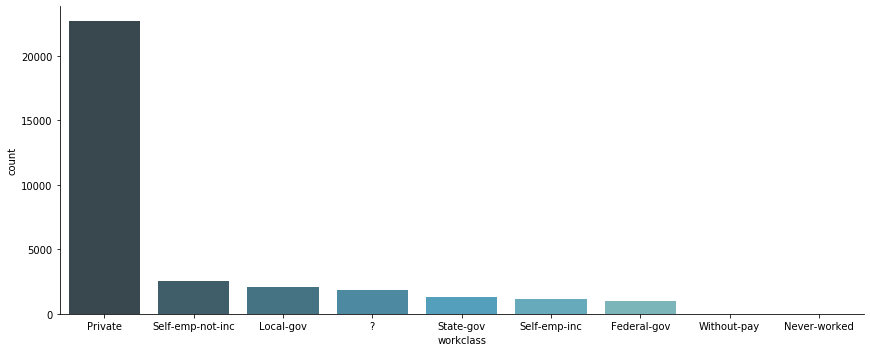

In [6]:
sns.catplot(x="workclass", kind="count", palette="GnBu_d", 
            height=5, aspect=12/5, data=income,
            order=income["workclass"].value_counts().index)

### fnlwgt
Is this final weight? The variable name is not clear.

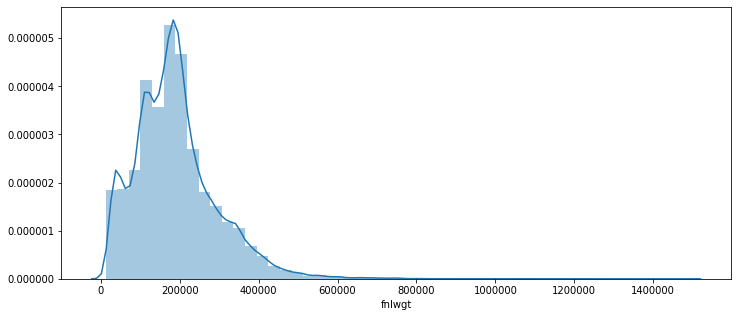

In [7]:
plt.figure(figsize=(12,5))
sns.distplot(income.fnlwgt)

### Education vs Education-Num
It seems like education and education-num contain the same general information. Meaning that education might be enough to keep as a factor since education-num is a subset of education. We can assume do not need that level of detail for looking at income.

In [8]:
income[['education','education-num']].drop_duplicates().sort_values(by='education-num')

,education,education-num
224,Preschool,1
160,1st-4th,2
56,5th-6th,3
15,7th-8th,4
6,9th,5
77,10th,6
3,11th,7
415,12th,8
2,HS-grad,9
10,Some-college,10


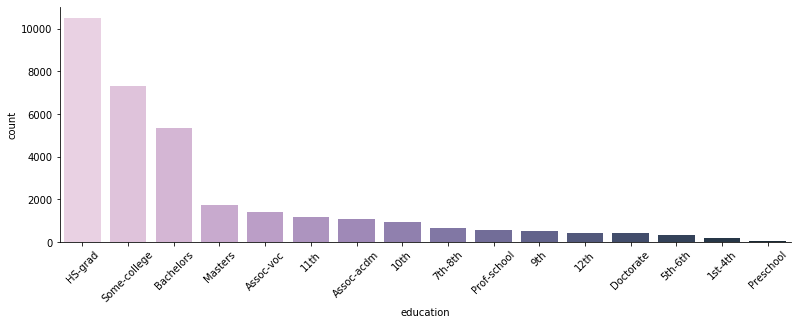

In [9]:
chart = sns.catplot(x="education", kind="count", palette="ch:2.5", 
            height=4, aspect=11/4, data=income,
            order=income.education.value_counts().index)
chart.set_xticklabels(rotation=45)

### Capital Gain

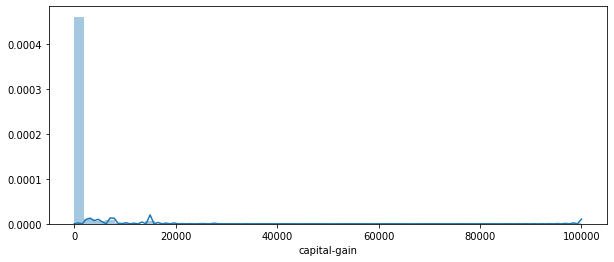

In [10]:
plt.figure(figsize=(10,4))
sns.distplot(income['capital-gain'])

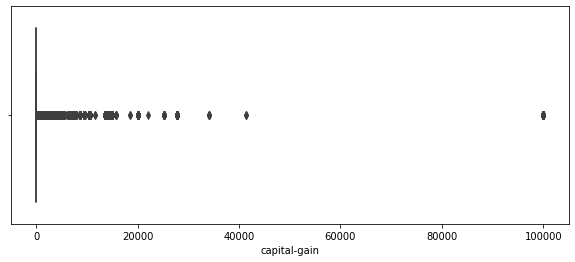

In [11]:
plt.figure(figsize=(10,4))
sns.boxplot(x=income["capital-gain"])

### Capital Loss

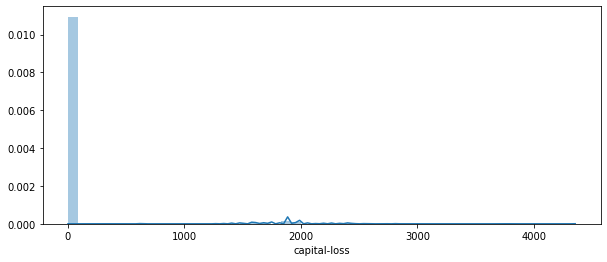

In [12]:
plt.figure(figsize=(10,4))
sns.distplot(income['capital-loss'])

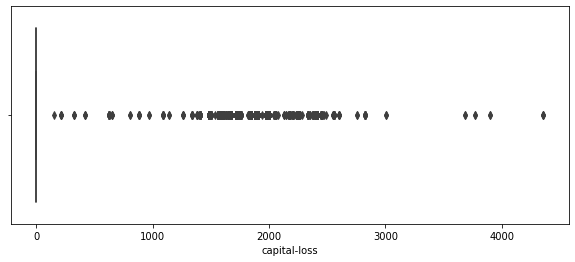

In [13]:
plt.figure(figsize=(10,4))
sns.boxplot(x=income["capital-loss"])

### Relationship

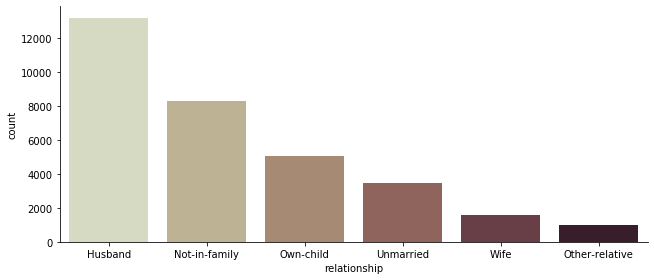

In [14]:
sns.catplot(x="relationship", kind="count", palette="ch:3.5", 
            height=4, aspect=9/4, data=income,
            order=income.relationship.value_counts().index)

### Marital Status
Possible combinations can be:
- Married-civ-spouse, Married-spouse-absent, Married-AF-spouse can all be combined into a Married category.
- Separated-marital-status and Divorced can be combined into a Divorced_or_Separated category.

In [15]:
income['marital-status'].unique()

array(['Never-married', 'Married-civ-spouse', 'Divorced',
       'Married-spouse-absent', 'Separated', 'Married-AF-spouse',
       'Widowed'], dtype=object)

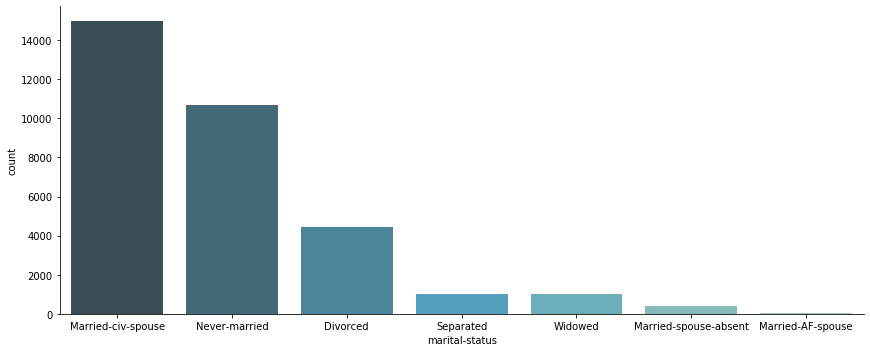

In [16]:
sns.catplot(x="marital-status", kind="count", palette="GnBu_d", 
            height=5, aspect=12/5, data=income,
            order=income["marital-status"].value_counts().index)

### Occupation

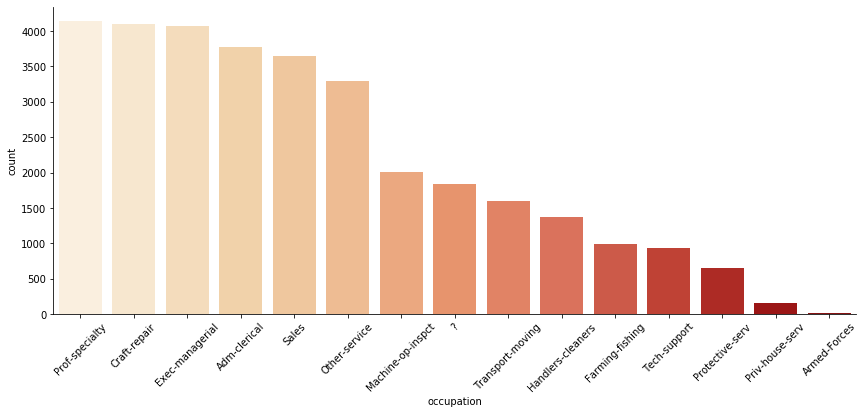

In [17]:
chart = sns.catplot(x="occupation", kind="count", palette="OrRd", 
            height=5, aspect=12/5, data=income,
            order=income.occupation.value_counts().index)
chart.set_xticklabels(rotation=45)

### Native Country
Majority is USA

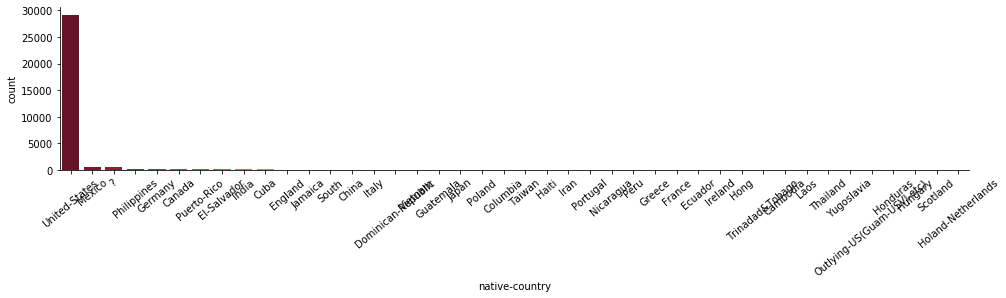

In [18]:
chart = sns.catplot(x="native-country", kind="count", palette="RdGy", 
            height=3, aspect=14/3, data=income,
            order=income['native-country'].value_counts().index)
chart.set_xticklabels(rotation=40)

### Hours Per Week

In [19]:
income['hours-per-week'].describe()

count    32561.000000
mean        40.437456
std         12.347429
min          1.000000
25%         40.000000
50%         40.000000
75%         45.000000
max         99.000000
Name: hours-per-week, dtype: float64

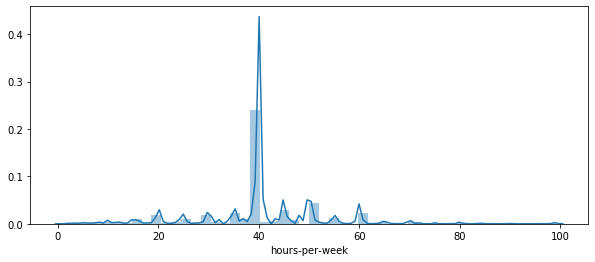

In [20]:
plt.figure(figsize=(10,4))
sns.distplot(income['hours-per-week'])

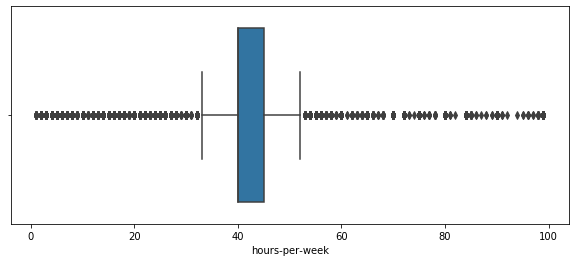

In [21]:
plt.figure(figsize=(10,4))
sns.boxplot(x=income["hours-per-week"])

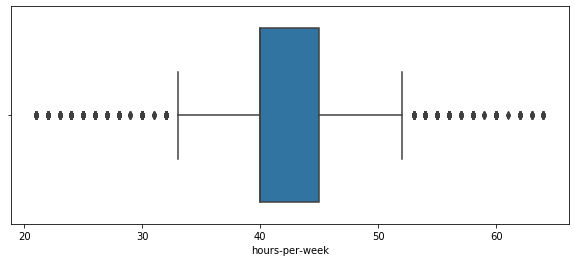

In [22]:
plt.figure(figsize=(10,4))
sns.boxplot(x=income[(income["hours-per-week"]>20) & (income['hours-per-week']<65)]['hours-per-week'])

In [23]:
income[(income["hours-per-week"]>20) & (income['hours-per-week']<65)]['hours-per-week'].shape[0]

28567

In [24]:
income['hours-per-week'].shape[0]

32561

In [25]:
income[(income["hours-per-week"]>20) & (income['hours-per-week']<65)]['hours-per-week'].shape[0] / income['hours-per-week'].shape[0] * 100

87.7337919597064

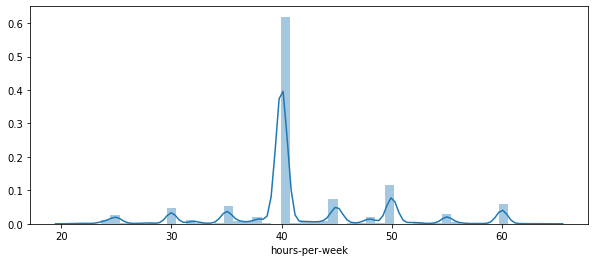

In [26]:
plt.figure(figsize=(10,4))
sns.distplot(income[(income["hours-per-week"]>20) & (income['hours-per-week']<65)]['hours-per-week'])

### Race

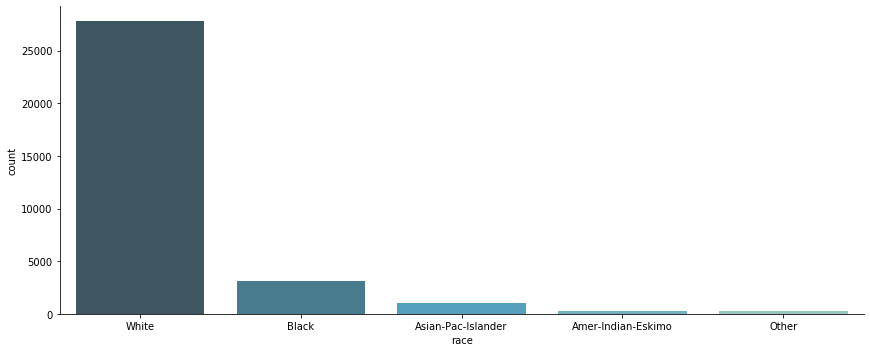

In [27]:
sns.catplot(x="race", kind="count", palette="GnBu_d", 
            height=5, aspect=12/5, data=income,
            order=income["race"].value_counts().index)

### Education & Ocupation

[Text(0, 0, 'Adm-clerical'),
 Text(0, 0, 'Exec-managerial'),
 Text(0, 0, 'Handlers-cleaners'),
 Text(0, 0, 'Prof-specialty'),
 Text(0, 0, 'Other-service'),
 Text(0, 0, 'Sales'),
 Text(0, 0, 'Craft-repair'),
 Text(0, 0, 'Transport-moving'),
 Text(0, 0, 'Farming-fishing'),
 Text(0, 0, 'Machine-op-inspct'),
 Text(0, 0, 'Tech-support'),
 Text(0, 0, '?'),
 Text(0, 0, 'Protective-serv'),
 Text(0, 0, 'Armed-Forces'),
 Text(0, 0, 'Priv-house-serv')]

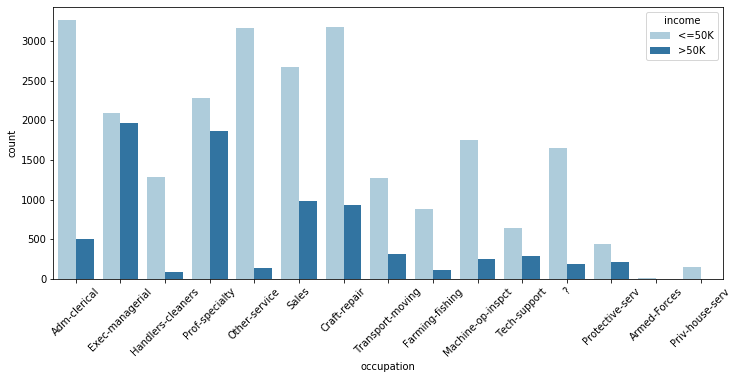

In [28]:
plt.figure(figsize=(12,5))
chart = sns.countplot(x="occupation", hue="income", 
                     data=income, palette="Paired")
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)

### Sex & Income

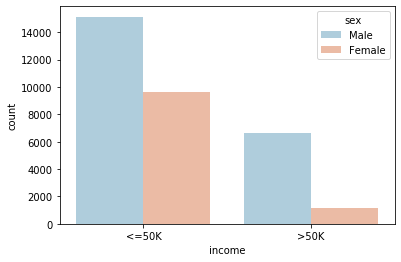

In [29]:
sns.countplot(x="income", hue="sex", data=income, palette="RdBu_r")

### Education & Income
After a Master's degree, the number of high incomes is higher than the low incomes.

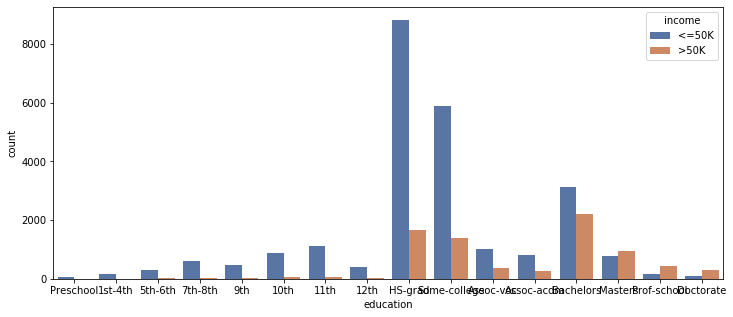

In [30]:
plt.figure(figsize=(12,5))
sns.countplot(x="education", hue="income", data=income, palette="deep",
              order=income[['education','education-num']].drop_duplicates()
              .sort_values(by='education-num')['education'].drop_duplicates())

### Age & Income

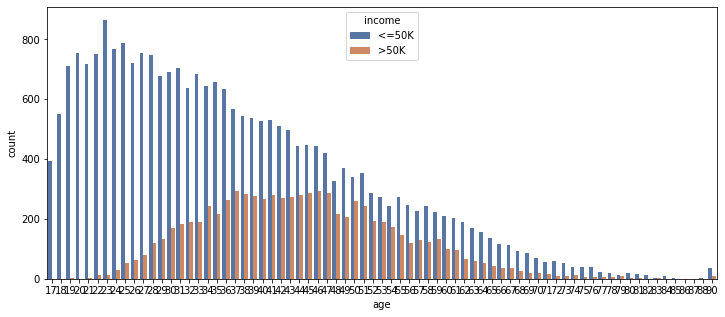

In [31]:
plt.figure(figsize=(12,5))
sns.countplot(x="age", hue="income", data=income, palette="deep")

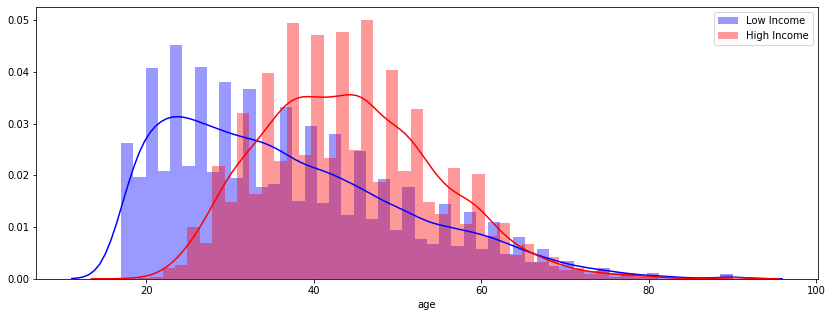

In [32]:
plt.figure(figsize=(14,5))
sns.distplot(income[income['income']=="<=50K"]['age'], color="blue", label='Low Income')
sns.distplot(income[income['income']==">50K"]['age'], color="red", label="High Income")
plt.legend(labels=['Low Income','High Income'])


## Question 2.
How would you transform your categorical variables and why? Which of them would you transform? If you do not want to transform any, justify why.


In [33]:
income.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [34]:
factors = [
    'workclass', 'education', 'marital-status', 'occupation', 'relationship',
    'race', 'sex', 'native-country', 'income'
]

In [35]:
# Checks for nulls
income.isnull().values.any()

False

In [36]:
# Handles nulls in case there are any
for factor in factors:
    income[factor].fillna(value=income[factor].mode()[0], inplace=True)

### Combined variables
- Working class
    - Local-gov, Sate-gov, and Federal-gov can be combined into Government_Work
    - Self-emp-not-inc and Self-emp-inc can be combined into Self_Employed
    - ?, Without-pay and Never-worked can be combined into Other
- Marital status
    - Married-civ-spouse, Married-spouse-absent, Married-AF-spouse can all be combined into a Married category.
    - Separated-marital-status and Divorced can be combined into a Divorced_or_Separated category.
- Race
    - Can be White, Black, and Other (with everything else combined here)
- Education
    - Associate level

### Transforming Education

In [37]:
income['education'].unique()

array(['Bachelors', 'HS-grad', '11th', 'Masters', '9th', 'Some-college',
       'Assoc-acdm', 'Assoc-voc', '7th-8th', 'Doctorate', 'Prof-school',
       '5th-6th', '10th', '1st-4th', 'Preschool', '12th'], dtype=object)

In [38]:
# Merges levels of education below high school
income['education'] = np.where(income['education'] == '11th', 'Not-HS-Grad', income['education'])
income['education'] = np.where(income['education'] == '9th', 'Not-HS-Grad', income['education'])
income['education'] = np.where(income['education'] == '7th-8th', 'Not-HS-Grad', income['education'])
income['education'] = np.where(income['education'] == '5th-6th', 'Not-HS-Grad', income['education'])
income['education'] = np.where(income['education'] == '10th', 'Not-HS-Grad', income['education'])
income['education'] = np.where(income['education'] == '1st-4th', 'Not-HS-Grad', income['education'])
income['education'] = np.where(income['education'] == 'Preschool', 'Not-HS-Grad', income['education'])
income['education'] = np.where(income['education'] == '12th', 'Not-HS-Grad', income['education'])
# Merges levels of education for associates level
income['education'] = np.where(income['education'] == 'Assoc-acdm', 'Associates', income['education'])
income['education'] = np.where(income['education'] == 'Assoc-voc', 'Associates', income['education'])

In [39]:
income.education.unique()

array(['Bachelors', 'HS-grad', 'Not-HS-Grad', 'Masters', 'Some-college',
       'Associates', 'Doctorate', 'Prof-school'], dtype=object)

### Transforming Working Class

In [40]:
income.workclass.unique()

array(['State-gov', 'Self-emp-not-inc', 'Private', 'Federal-gov',
       'Local-gov', '?', 'Self-emp-inc', 'Without-pay', 'Never-worked'],
      dtype=object)

In [41]:
# Merges levels of workclass that fall into Government
income['workclass'] = np.where(income['workclass'] == 'Local-gov', 'Gov', income['workclass'])
income['workclass'] = np.where(income['workclass'] == 'State-gov', 'Gov', income['workclass'])
income['workclass'] = np.where(income['workclass'] == 'Federal-gov', 'Gov', income['workclass'])
# Merges levels of workclass that fall into Self-employed
income['workclass'] = np.where(income['workclass'] == 'Self-emp-not-inc', 'Self_emp', income['workclass'])
income['workclass'] = np.where(income['workclass'] == 'Self-emp-inc', 'Self_emp', income['workclass'])
# Merges levels of workclass that fall into Other
income['workclass'] = np.where(income['workclass'] == '?', 'Other', income['workclass'])
income['workclass'] = np.where(income['workclass'] == 'Without-pay', 'Other', income['workclass'])


### Transforming Race

In [42]:
income.race.unique()

array(['White', 'Black', 'Asian-Pac-Islander', 'Amer-Indian-Eskimo',
       'Other'], dtype=object)

In [43]:
# Merges minorities into Other
income['race'] = np.where(income['race'] == 'Asian-Pac-Islander', 'Other', income['race'])
income['race'] = np.where(income['race'] == 'Amer-Indian-Eskimo', 'Other', income['race'])


### Transforming Marital Status

In [44]:
income['marital-status'].unique()

array(['Never-married', 'Married-civ-spouse', 'Divorced',
       'Married-spouse-absent', 'Separated', 'Married-AF-spouse',
       'Widowed'], dtype=object)

In [45]:
# Merges levels of marital status that fall into Married
income['marital-status'] = np.where(income['marital-status'] == 'Married-civ-spouse', 'Married', income['marital-status'])
income['marital-status'] = np.where(income['marital-status'] == 'Married-spouse-absent', 'Married', income['marital-status'])
income['marital-status'] = np.where(income['marital-status'] == 'Married-AF-spouse', 'Married', income['marital-status'])
# Merges levels of marital status that fall into Divorced_or_Separated
income['marital-status'] = np.where(income['marital-status'] == 'Separated', 'Divorced_or_Separated', income['marital-status'])
income['marital-status'] = np.where(income['marital-status'] == 'Divorced', 'Divorced_or_Separated', income['marital-status'])


In [46]:
#assigning levels to the values of categorical variables
income_fact = income.copy()
mapping_levels = []
for factor in factors:
    income_fact[factor] = income_fact[factor].factorize(sort = True)[0]
    mapping_levels.append(income_fact[factor].factorize(sort = True)[1])
income_fact.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,0,77516,1,13,2,1,1,2,1,2174,0,40,39,0
1,50,4,83311,1,13,1,4,0,2,1,0,0,13,39,0
2,38,3,215646,3,9,0,6,1,2,1,0,0,40,39,0
3,53,3,234721,5,7,1,6,0,0,1,0,0,40,39,0
4,28,3,338409,1,13,1,10,5,0,0,0,0,40,5,0


In [47]:
# Creates a correlation matrix of the data
income_fact.corr(method='spearman')

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
age,1.000000,0.034091,-0.078141,-0.076983,0.066345,-0.394977,-0.004810,-0.321515,0.028056,0.100373,0.124948,0.058484,0.142907,0.007508,0.272962
workclass,0.034091,1.000000,-0.015506,-0.006799,-0.056307,-0.039712,0.143764,-0.112655,0.087370,0.126925,0.030524,0.012238,0.148242,-0.027769,0.044932
fnlwgt,-0.078141,-0.015506,1.000000,0.010777,-0.035706,0.019549,0.001656,0.013734,-0.053952,0.025078,-0.006039,-0.006914,-0.021621,-0.079336,-0.010738
education,-0.076983,-0.006799,0.010777,1.000000,-0.287868,0.047474,-0.055512,0.074108,-0.024707,-0.029639,-0.042120,-0.025516,-0.112541,-0.018027,-0.121944
education-num,0.066345,-0.056307,-0.035706,-0.287868,1.000000,-0.026398,0.115080,-0.096114,0.056429,0.006283,0.119140,0.074749,0.167215,0.050102,0.329682
marital-status,-0.394977,-0.039712,0.019549,0.047474,-0.026398,1.000000,-0.003918,0.207021,-0.036766,-0.074158,-0.060629,-0.032385,-0.188765,-0.009206,-0.180698
occupation,-0.004810,0.143764,0.001656,-0.055512,0.115080,-0.003918,1.000000,-0.075321,0.009430,0.078789,0.020514,0.019944,0.089875,-0.007114,0.082149
relationship,-0.321515,-0.112655,0.013734,0.074108,-0.096114,0.207021,-0.075321,1.000000,-0.142200,-0.617570,-0.100721,-0.067608,-0.301436,-0.013201,-0.329913
race,0.028056,0.087370,-0.053952,-0.024707,0.056429,-0.036766,0.009430,-0.142200,1.000000,0.107320,0.030212,0.020789,0.079843,0.150150,0.087640
sex,0.100373,0.126925,0.025078,-0.029639,0.006283,-0.074158,0.078789,-0.617570,0.107320,1.000000,0.066646,0.042154,0.264941,-0.006870,0.215980


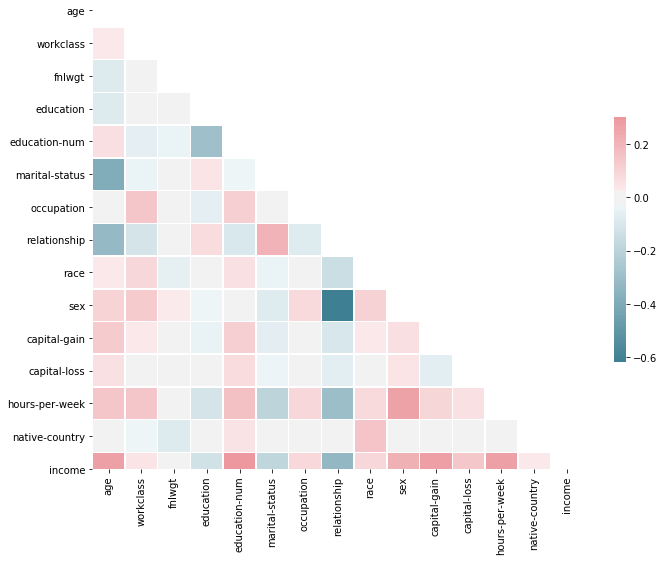

In [48]:
# Compute the correlation matrix
corr = income_fact.corr(method='spearman')

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [49]:
# Checks for class imbalance
print(income['income'].value_counts())
print(str(round(income['income'].value_counts()[1]*100/income.shape[0],2)) + '%')

<=50K    24720
>50K      7841
Name: income, dtype: int64
24.08%


In [50]:
# Checks for class imbalance again
print(income_fact['income'].value_counts())
print(str(round(income_fact['income'].value_counts()[1]*100/income.shape[0],2)) + '%')

0    24720
1     7841
Name: income, dtype: int64
24.08%


### Dummy Variables

In [51]:
income_d = income_fact.copy()
for var in factors:
    if var != 'hours-per-week':
        cat_list='var'+'_'+var
        cat_list = pd.get_dummies(income_d[var], prefix=var, drop_first=True)
        income_d = pd.concat([income_d,cat_list], axis = 1)
        income_d = income_d.drop(var, 1)
income_d.head()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,workclass_1,workclass_2,workclass_3,workclass_4,...,native-country_33,native-country_34,native-country_35,native-country_36,native-country_37,native-country_38,native-country_39,native-country_40,native-country_41,income_1
0,39,77516,13,2174,0,40,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,50,83311,13,0,0,13,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
2,38,215646,9,0,0,40,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
3,53,234721,7,0,0,40,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
4,28,338409,13,0,0,40,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [52]:
income_d.shape

(32561, 84)

In [53]:
income_d.columns.tolist()

['age',
 'fnlwgt',
 'education-num',
 'capital-gain',
 'capital-loss',
 'hours-per-week',
 'workclass_1',
 'workclass_2',
 'workclass_3',
 'workclass_4',
 'education_1',
 'education_2',
 'education_3',
 'education_4',
 'education_5',
 'education_6',
 'education_7',
 'marital-status_1',
 'marital-status_2',
 'marital-status_3',
 'occupation_1',
 'occupation_2',
 'occupation_3',
 'occupation_4',
 'occupation_5',
 'occupation_6',
 'occupation_7',
 'occupation_8',
 'occupation_9',
 'occupation_10',
 'occupation_11',
 'occupation_12',
 'occupation_13',
 'occupation_14',
 'relationship_1',
 'relationship_2',
 'relationship_3',
 'relationship_4',
 'relationship_5',
 'race_1',
 'race_2',
 'sex_1',
 'native-country_1',
 'native-country_2',
 'native-country_3',
 'native-country_4',
 'native-country_5',
 'native-country_6',
 'native-country_7',
 'native-country_8',
 'native-country_9',
 'native-country_10',
 'native-country_11',
 'native-country_12',
 'native-country_13',
 'native-country_14',
 '

## Question 3.
Use a technique of your choice to eliminate some of the features. Explain your method.


In [54]:
# A combined approach of corelation matrix and RFE

In [55]:
factors = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country', 'income']

In [56]:
income_d.head()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,workclass_1,workclass_2,workclass_3,workclass_4,...,native-country_33,native-country_34,native-country_35,native-country_36,native-country_37,native-country_38,native-country_39,native-country_40,native-country_41,income_1
0,39,77516,13,2174,0,40,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,50,83311,13,0,0,13,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
2,38,215646,9,0,0,40,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
3,53,234721,7,0,0,40,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
4,28,338409,13,0,0,40,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [57]:
income_dummy = income_d.copy()
X = income_dummy.drop(['income_1'], 1)  #independent columns .
y = income_dummy['income_1']   #target column i.e price range

In [58]:
# create a base classifier used to evaluate a subset of attributes
model = LogisticRegression()
# create the RFE model and select 3 attributes
rfe = RFE(model, 10)
rfe = rfe.fit(X, y)
# summarize the selection of the attributes
print(rfe.support_)
print(rfe.ranking_)

[ True  True  True  True  True  True False False  True False False False
 False False False False False  True  True False False False False False
 False False False False False False False False False False  True False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False]
[ 1  1  1  1  1  1 65 15  1 28 12 26  3 14  6 25  9  1  1 21 11 70 19 10
 22 17 16  7 31 13 32 29 34 27  1 20  4  8 18 24  5 23 69 66 68 38 47 36
 49 37 61 51 56 58 39 44 74 67 63 71 43 54 57 52 40 53 60 30 48 55 50 73
 46 42 33 72 41 45 64 59  2 35 62]


## Question 4.
Fit a regression model to predict whether income of an individual is more than 50k. What regression model do you use? Why? How well is your model performing?

To predict whether the income of an individual is more than 50K , we will use a logistic regression model. 


In [59]:
factors_new = ['workclass', 'education', 'marital-status','occupation', 'sex', 'income']

In [60]:
income_fact_c = income_fact.copy()
for var in factors_new:
    if var != 'income':
        cat_list='var'+'_'+var
        cat_list = pd.get_dummies(income_fact_c[var], prefix=var, drop_first=True)
        income_fact_c = pd.concat([income_fact_c,cat_list], axis = 1)
        income_fact_c = income_fact_c.drop(var, 1)

In [61]:
income_fact_c = income_fact_c.drop(['fnlwgt','relationship','race','native-country'], axis = 1)
income_fact_c.head()

,age,education-num,capital-gain,capital-loss,hours-per-week,income,workclass_1,workclass_2,workclass_3,workclass_4,...,occupation_6,occupation_7,occupation_8,occupation_9,occupation_10,occupation_11,occupation_12,occupation_13,occupation_14,sex_1
0,39,13,2174,0,40,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,50,13,0,0,13,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
2,38,9,0,0,40,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,1
3,53,7,0,0,40,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,1
4,28,13,0,0,40,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0


In [62]:
#70% records being sent into training set 
income_fact_c['income'] = income_fact_c['income'].factorize()[0]
pts = np.random.rand(len(income_fact_c)) < 0.7

income_train_new = income_fact_c[pts]
income_test_new = income_fact_c[~pts]

X_train_new = income_train_new.copy()
X_train_new = X_train_new.drop('income', 1)
Y_train_new = income_train_new['income']

#fitting the model
logreg = LogisticRegression()
logreg.fit(X_train_new, Y_train_new)

C:\Users\whn97\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [63]:
#generating confusion matrix
X_test_new = income_test_new.copy()
X_test_new = X_test_new.drop('income', 1)
Y_test_new = income_test_new['income']
Y_pred_new = logreg.predict(X_test_new)
confusion_matrix_new = confusion_matrix(Y_test_new, Y_pred_new)
print(confusion_matrix_new)

[[6783  555]
 [1132 1251]]


Model Accuracy

In [64]:
logreg.score(X_test_new,Y_test_new)

0.8264581833144738

In [65]:
print(classification_report(Y_test_new, logreg.predict(X_test_new)))

              precision    recall  f1-score   support

           0       0.86      0.92      0.89      7338
           1       0.69      0.52      0.60      2383

    accuracy                           0.83      9721
   macro avg       0.77      0.72      0.74      9721
weighted avg       0.82      0.83      0.82      9721



## Question 5.
Use the income dataset to regress work hours on the rest of the data. Compare the R^2 with R^2 of another model that you fit with only the significant variables. Explore some interaction terms and explain why they were of interest.


In [66]:
income_fact.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,0,77516,1,13,2,1,1,2,1,2174,0,40,39,0
1,50,4,83311,1,13,1,4,0,2,1,0,0,13,39,0
2,38,3,215646,3,9,0,6,1,2,1,0,0,40,39,0
3,53,3,234721,5,7,1,6,0,0,1,0,0,40,39,0
4,28,3,338409,1,13,1,10,5,0,0,0,0,40,5,0


In [67]:
print(factors)

['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country', 'income']


## Part 1
test-training set split and fitting

In [68]:
np.random.seed(12345)

In [69]:
# 70% records being sent into training set 
income_ln = income_d.copy()
income_ln['hours-per-week'] = income_ln['hours-per-week'].factorize()[0]
pts = np.random.rand(len(income_ln)) < 0.7

income_train = income_ln[pts]
income_test = income_ln[~pts]

X_train = income_train.copy()
X_train = X_train.drop('hours-per-week', 1)
Y_train = income_train['hours-per-week']

#fitting the model
linreg = LinearRegression()
linreg.fit(X_train, Y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [70]:
r_sq = linreg.score(X_train, Y_train)
print('coefficient of determination:', r_sq)

coefficient of determination: 0.04402679943955656


In [71]:
mod = sm.OLS(Y_train,X_train)
lnfit = mod.fit()
print(lnfit.summary())

                                 OLS Regression Results                                
Dep. Variable:         hours-per-week   R-squared (uncentered):                   0.296
Model:                            OLS   Adj. R-squared (uncentered):              0.293
Method:                 Least Squares   F-statistic:                              114.7
Date:                Thu, 16 Jan 2020   Prob (F-statistic):                        0.00
Time:                        23:45:28   Log-Likelihood:                         -89255.
No. Observations:               22739   AIC:                                  1.787e+05
Df Residuals:                   22656   BIC:                                  1.793e+05
Df Model:                          83                                                  
Covariance Type:            nonrobust                                                  
                        coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------

## Part 2
Eliminating insignificant variables

### Approach 1: Eliminating relationship, native country, edu-num
- Relationship was eliminated because it is highly correlated with marital status
- Education number was eliminated because this information is already included in Education
- Native country was eliminated because most of the IVs for this variable showed as insignificant above

### Dummy Variables

In [72]:
new_factors = ['workclass', 'education', 'marital-status', 'occupation', 'race', 'sex', 'income']
new_factors

['workclass',
 'education',
 'marital-status',
 'occupation',
 'race',
 'sex',
 'income']

In [73]:
income_fact.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,0,77516,1,13,2,1,1,2,1,2174,0,40,39,0
1,50,4,83311,1,13,1,4,0,2,1,0,0,13,39,0
2,38,3,215646,3,9,0,6,1,2,1,0,0,40,39,0
3,53,3,234721,5,7,1,6,0,0,1,0,0,40,39,0
4,28,3,338409,1,13,1,10,5,0,0,0,0,40,5,0


In [74]:
income_new = income_fact.copy()
income_new = income_new.drop(columns=['education-num'], axis=1)
income_new = income_new.drop(columns=['relationship'], axis=1)
income_new = income_new.drop(columns=['native-country'], axis=1)
for var in new_factors:
    if var != 'hours-per-week':
        cat_list='var'+'_'+var
        cat_list = pd.get_dummies(income_new[var], prefix=var, drop_first=True)
        income_new = pd.concat([income_new,cat_list], axis = 1)
        income_new = income_new.drop(var, 1)
income_new.head()

,age,fnlwgt,capital-gain,capital-loss,hours-per-week,workclass_1,workclass_2,workclass_3,workclass_4,education_1,...,occupation_9,occupation_10,occupation_11,occupation_12,occupation_13,occupation_14,race_1,race_2,sex_1,income_1
0,39,77516,2174,0,40,0,0,0,0,1,...,0,0,0,0,0,0,0,1,1,0
1,50,83311,0,0,13,0,0,0,1,1,...,0,0,0,0,0,0,0,1,1,0
2,38,215646,0,0,40,0,0,1,0,0,...,0,0,0,0,0,0,0,1,1,0
3,53,234721,0,0,40,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
4,28,338409,0,0,40,0,0,1,0,1,...,0,1,0,0,0,0,0,0,0,0


In [75]:
income_new.shape

(32561, 37)

In [76]:
income_new.columns.tolist()

['age',
 'fnlwgt',
 'capital-gain',
 'capital-loss',
 'hours-per-week',
 'workclass_1',
 'workclass_2',
 'workclass_3',
 'workclass_4',
 'education_1',
 'education_2',
 'education_3',
 'education_4',
 'education_5',
 'education_6',
 'education_7',
 'marital-status_1',
 'marital-status_2',
 'marital-status_3',
 'occupation_1',
 'occupation_2',
 'occupation_3',
 'occupation_4',
 'occupation_5',
 'occupation_6',
 'occupation_7',
 'occupation_8',
 'occupation_9',
 'occupation_10',
 'occupation_11',
 'occupation_12',
 'occupation_13',
 'occupation_14',
 'race_1',
 'race_2',
 'sex_1',
 'income_1']

### Test-Training Set Split and Fitting

In [77]:
# 70% records being sent into training set 
income_ln_red = income_new.copy()
income_ln_red['hours-per-week'] = income_ln_red['hours-per-week'].factorize()[0]
pts = np.random.rand(len(income_ln_red)) < 0.7

income_train_red = income_ln_red[pts]
income_test_red = income_ln_red[~pts]

X_train_red = income_train_red.copy()
X_train_red = X_train_red.drop('hours-per-week', 1)
Y_train_red = income_train_red['hours-per-week']

X_test_red = income_test_red.copy()
X_test_red = X_test_red.drop('hours-per-week', 1)
Y_test_red = income_test_red['hours-per-week']

#fitting the model
linreg_red = LinearRegression()
linreg_red.fit(X_train_red, Y_train_red)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [78]:
r_sq_red = linreg_red.score(X_train_red, Y_train_red)
print('coefficient of determination:', r_sq_red)

coefficient of determination: 0.04114871230826933


In [79]:
mod_red = sm.OLS(Y_train_red,X_train_red)
lnfit_red = mod_red.fit()
print(lnfit_red.summary())

                                 OLS Regression Results                                
Dep. Variable:         hours-per-week   R-squared (uncentered):                   0.291
Model:                            OLS   Adj. R-squared (uncentered):              0.290
Method:                 Least Squares   F-statistic:                              260.0
Date:                Thu, 16 Jan 2020   Prob (F-statistic):                        0.00
Time:                        23:45:28   Log-Likelihood:                         -89810.
No. Observations:               22823   AIC:                                  1.797e+05
Df Residuals:                   22787   BIC:                                  1.800e+05
Df Model:                          36                                                  
Covariance Type:            nonrobust                                                  
                       coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------

### Approach 2: RFE

In [80]:
# test the best number of variables
for i in range(1, 37):
    rfe = RFE(linreg, i)
    rfe = rfe.fit(X_train_red, Y_train_red)
    X_train_rfe = rfe.transform(X_train_red)
    X_test_rfe = rfe.transform(X_test_red)
    linreg.fit(X_train_rfe, Y_train_red)
    r_sq = linreg.score(X_train_rfe, Y_train_red)
    Y_pred = linreg.predict(X_test_rfe)
    mse = mean_squared_error(Y_test_red, Y_pred)
    print(i, 'coefficient of determination:', r_sq, 'mse:', mse)

1 coefficient of determination: 0.00016258115820955155 mse: 153.0144107799293
2 coefficient of determination: 0.005053258155121586 mse: 153.10179142560906
3 coefficient of determination: 0.012635459255603165 mse: 152.56231553635956
4 coefficient of determination: 0.013194928827587993 mse: 152.39451381408944
5 coefficient of determination: 0.013225126656047026 mse: 152.41906781087317
6 coefficient of determination: 0.01622467947841244 mse: 151.8028609647357
7 coefficient of determination: 0.0169291319064645 mse: 151.87579892288392
8 coefficient of determination: 0.021907263306728764 mse: 151.0354299449694
9 coefficient of determination: 0.027159847434772955 mse: 150.4539308833601
10 coefficient of determination: 0.027849910487305785 mse: 150.4474659197326
11 coefficient of determination: 0.028356251688042455 mse: 150.37742287030872
12 coefficient of determination: 0.03131781067042261 mse: 149.87606656806776
13 coefficient of determination: 0.03203183185821268 mse: 149.85559097005836
14 

Considering p-value, R^2 and MSE, the best model consists of 33 variables.

In [81]:
#Find the 33 variables
rfe = RFE(linreg, 33)
rfe = rfe.fit(X_train_red, Y_train_red)
print(rfe.support_)
print(rfe.ranking_)

[ True False False False  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True]
[1 4 3 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [82]:
feature = X_train_red.columns[rfe.get_support()]
feature

Index(['age', 'workclass_1', 'workclass_2', 'workclass_3', 'workclass_4',
       'education_1', 'education_2', 'education_3', 'education_4',
       'education_5', 'education_6', 'education_7', 'marital-status_1',
       'marital-status_2', 'marital-status_3', 'occupation_1', 'occupation_2',
       'occupation_3', 'occupation_4', 'occupation_5', 'occupation_6',
       'occupation_7', 'occupation_8', 'occupation_9', 'occupation_10',
       'occupation_11', 'occupation_12', 'occupation_13', 'occupation_14',
       'race_1', 'race_2', 'sex_1', 'income_1'],
      dtype='object')

In [83]:
len(feature)

33

In [84]:
income_rfe = income_new.copy()
income_rfe = income_rfe.drop('fnlwgt', 1)
income_rfe = income_rfe.drop('capital-gain', 1)
income_rfe = income_rfe.drop('capital-loss', 1)

In [85]:
income_rfe_c = income_rfe.copy()
X_rfe = income_rfe_c.drop('hours-per-week', 1)
Y_rfe = income_rfe_c['hours-per-week']

In [86]:
mod_rfe = sm.OLS(Y_rfe,X_rfe)
lnfit_rfe = mod_rfe.fit()
print(lnfit_rfe.summary())

                                 OLS Regression Results                                
Dep. Variable:         hours-per-week   R-squared (uncentered):                   0.929
Model:                            OLS   Adj. R-squared (uncentered):              0.929
Method:                 Least Squares   F-statistic:                          1.286e+04
Date:                Thu, 16 Jan 2020   Prob (F-statistic):                        0.00
Time:                        23:45:36   Log-Likelihood:                     -1.2510e+05
No. Observations:               32561   AIC:                                  2.503e+05
Df Residuals:                   32528   BIC:                                  2.505e+05
Df Model:                          33                                                  
Covariance Type:            nonrobust                                                  
                       coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------

## Part 3
Interaction terms

In [87]:
income_d.head()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,workclass_1,workclass_2,workclass_3,workclass_4,...,native-country_33,native-country_34,native-country_35,native-country_36,native-country_37,native-country_38,native-country_39,native-country_40,native-country_41,income_1
0,39,77516,13,2174,0,40,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,50,83311,13,0,0,13,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
2,38,215646,9,0,0,40,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
3,53,234721,7,0,0,40,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
4,28,338409,13,0,0,40,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [88]:
income_d_copy = income_d.copy()
X_rfe['sex*age'] = income_d_copy['sex_1']*income_d_copy['age']
X_rfe['sex*education-num'] = income_d_copy['sex_1']*income_d_copy['education-num']
X_rfe['age*education-num'] = income_d_copy['age']*income_d_copy['education-num']
X_rfe['age*income1'] = income_d_copy['age']*income_d_copy['income_1']
X_rfe['income1*education-num'] = income_d_copy['income_1']*income_d_copy['education-num']

In [89]:
mod_rfe = sm.OLS(Y_rfe,X_rfe)
lnfit_rfe = mod_rfe.fit()
print(lnfit_rfe.summary())

                                 OLS Regression Results                                
Dep. Variable:         hours-per-week   R-squared (uncentered):                   0.929
Model:                            OLS   Adj. R-squared (uncentered):              0.929
Method:                 Least Squares   F-statistic:                          1.126e+04
Date:                Thu, 16 Jan 2020   Prob (F-statistic):                        0.00
Time:                        23:45:36   Log-Likelihood:                     -1.2497e+05
No. Observations:               32561   AIC:                                  2.500e+05
Df Residuals:                   32523   BIC:                                  2.503e+05
Df Model:                          38                                                  
Covariance Type:            nonrobust                                                  
                            coef    std err          t      P>|t|      [0.025      0.975]
------------------------------

All interaction terms are significant.

## Question 6.
Regress work hours of only people who are working in Sales. Once you fit a reasonable (as per your judgement) model for this data, compare the R^2 with the ones you calculated for Question 5. Explain your findings.


In [90]:
#Select 'sales' people
income_sales = income[income['occupation']=='Sales']

In [91]:
income_sales.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
13,32,Private,205019,Associates,12,Never-married,Sales,Not-in-family,Black,Male,0,0,50,United-States,<=50K
18,38,Private,28887,Not-HS-Grad,7,Married,Sales,Husband,White,Male,0,0,50,United-States,<=50K
31,20,Private,266015,Some-college,10,Never-married,Sales,Own-child,Black,Male,0,0,44,United-States,<=50K
38,31,Private,84154,Some-college,10,Married,Sales,Husband,White,Male,0,0,38,?,>50K
60,30,Private,59496,Bachelors,13,Married,Sales,Husband,White,Male,2407,0,40,United-States,<=50K


In [92]:
sfactors = [
    'workclass', 'education', 'marital-status', 'relationship',
    'race', 'sex', 'native-country', 'income'
]

In [93]:
#assigning levels to the values of categorical variables
income_fact_sales = income_sales.copy()
income_fact_sales = income_fact_sales.drop('occupation', 1)
mapping_levels = []
for sfactor in sfactors:
    income_fact_sales[sfactor] = income_fact_sales[sfactor].factorize(sort = True)[0]
    mapping_levels.append(income_fact_sales[sfactor].factorize(sort = True)[1])
income_fact_sales.head()

,age,workclass,fnlwgt,education,education-num,marital-status,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
13,32,1,205019,0,12,2,1,0,1,0,0,50,34,0
18,38,1,28887,5,7,1,0,2,1,0,0,50,34,0
31,20,1,266015,7,10,2,3,0,1,0,0,44,34,0
38,31,1,84154,7,10,1,0,2,1,0,0,38,0,1
60,30,1,59496,1,13,1,0,2,1,2407,0,40,34,0


In [94]:
#Create dummy variables
income_sales_d = income_fact_sales.copy()
for var in sfactors:
    if var != 'hours-per-week':
        cat_list='var'+'_'+var
        cat_list = pd.get_dummies(income_sales_d[var], prefix=var, drop_first=True)
        income_sales_d = pd.concat([income_sales_d,cat_list], axis = 1)
        income_sales_d = income_sales_d.drop(var, 1)
income_sales_d.head()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,workclass_1,workclass_2,education_1,education_2,...,native-country_27,native-country_28,native-country_29,native-country_30,native-country_31,native-country_32,native-country_33,native-country_34,native-country_35,income_1
13,32,205019,12,0,0,50,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
18,38,28887,7,0,0,50,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
31,20,266015,10,0,0,44,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
38,31,84154,10,0,0,38,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
60,30,59496,13,2407,0,40,1,0,1,0,...,0,0,0,0,0,0,0,1,0,0


## Part 1
test-training set split and fitting

In [95]:
np.random.seed(12345)

In [96]:
# 70% records being sent into training set 
income_s = income_sales_d.copy()
income_s['hours-per-week'] = income_s['hours-per-week'].factorize()[0]
pts = np.random.rand(len(income_s)) < 0.7

income_train = income_s[pts]
income_test = income_s[~pts]

X_train = income_train.copy()
X_train = X_train.drop('hours-per-week', 1)
Y_train = income_train['hours-per-week']

#fitting the model
linreg = LinearRegression()
linreg.fit(X_train, Y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [97]:
r_sq = linreg.score(X_train, Y_train)
print('coefficient of determination:', r_sq)

coefficient of determination: 0.05460793450258028


In [98]:
mod = sm.OLS(Y_train,X_train)
lnfit = mod.fit()
print(lnfit.summary())

                                 OLS Regression Results                                
Dep. Variable:         hours-per-week   R-squared (uncentered):                   0.450
Model:                            OLS   Adj. R-squared (uncentered):              0.437
Method:                 Least Squares   F-statistic:                              34.75
Date:                Thu, 16 Jan 2020   Prob (F-statistic):                   1.34e-277
Time:                        23:45:37   Log-Likelihood:                         -9781.2
No. Observations:                2563   AIC:                                  1.968e+04
Df Residuals:                    2504   BIC:                                  2.003e+04
Df Model:                          59                                                  
Covariance Type:            nonrobust                                                  
                        coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------

## Part 2 Remove variables

### Approach 1
remove education-num, relationship, native-country as Question 5

In [99]:
new_factors = ['workclass', 'education', 'marital-status', 'race', 'sex', 'income']
new_factors

['workclass', 'education', 'marital-status', 'race', 'sex', 'income']

In [100]:
income_new = income_fact_sales.copy()
income_new = income_new.drop(columns=['education-num'], axis=1)
income_new = income_new.drop(columns=['relationship'], axis=1)
income_new = income_new.drop(columns=['native-country'], axis=1)
for var in new_factors:
    if var != 'hours-per-week':
        cat_list='var'+'_'+var
        cat_list = pd.get_dummies(income_new[var], prefix=var, drop_first=True)
        income_new = pd.concat([income_new,cat_list], axis = 1)
        income_new = income_new.drop(var, 1)
income_new.head()

,age,fnlwgt,capital-gain,capital-loss,hours-per-week,workclass_1,workclass_2,education_1,education_2,education_3,...,education_5,education_6,education_7,marital-status_1,marital-status_2,marital-status_3,race_1,race_2,sex_1,income_1
13,32,205019,0,0,50,1,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
18,38,28887,0,0,50,1,0,0,0,0,...,1,0,0,1,0,0,0,1,1,0
31,20,266015,0,0,44,1,0,0,0,0,...,0,0,1,0,1,0,0,0,1,0
38,31,84154,0,0,38,1,0,0,0,0,...,0,0,1,1,0,0,0,1,1,1
60,30,59496,2407,0,40,1,0,1,0,0,...,0,0,0,1,0,0,0,1,1,0


In [101]:
# 70% records being sent into training set 
income_s_red = income_new.copy()
income_s_red['hours-per-week'] = income_s_red['hours-per-week'].factorize()[0]
pts = np.random.rand(len(income_s_red)) < 0.7

income_train_red = income_s_red[pts]
income_test_red = income_s_red[~pts]

X_train_red = income_train_red.copy()
X_train_red = X_train_red.drop('hours-per-week', 1)
Y_train_red = income_train_red['hours-per-week']

X_test_red = income_test_red.copy()
X_test_red = X_test_red.drop('hours-per-week', 1)
Y_test_red = income_test_red['hours-per-week']

#fitting the model
linreg_red = LinearRegression()
linreg_red.fit(X_train_red, Y_train_red)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [102]:
r_sq_red = linreg_red.score(X_train_red, Y_train_red)
print('coefficient of determination:', r_sq_red)

coefficient of determination: 0.030958923504051165


In [103]:
mod_red = sm.OLS(Y_train_red,X_train_red)
lnfit_red = mod_red.fit()
print(lnfit_red.summary())

                                 OLS Regression Results                                
Dep. Variable:         hours-per-week   R-squared (uncentered):                   0.431
Model:                            OLS   Adj. R-squared (uncentered):              0.427
Method:                 Least Squares   F-statistic:                              93.89
Date:                Thu, 16 Jan 2020   Prob (F-statistic):                   3.08e-285
Time:                        23:45:37   Log-Likelihood:                         -9583.0
No. Observations:                2498   AIC:                                  1.921e+04
Df Residuals:                    2478   BIC:                                  1.932e+04
Df Model:                          20                                                  
Covariance Type:            nonrobust                                                  
                       coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------

### Approach 2: RFE

In [104]:
# test the best number of variables
for i in range(1, 20):
    rfe = RFE(linreg, i)
    rfe = rfe.fit(X_train_red, Y_train_red)
    X_train_rfe = rfe.transform(X_train_red)
    X_test_rfe = rfe.transform(X_test_red)
    linreg.fit(X_train_rfe, Y_train_red)
    r_sq = linreg.score(X_train_rfe, Y_train_red)
    Y_pred = linreg.predict(X_test_rfe)
    mse = mean_squared_error(Y_test_red, Y_pred)
    print(i, 'coefficient of determination:', r_sq, 'mse:', mse)

1 coefficient of determination: 0.0010008543051566177 mse: 120.66334484301134
2 coefficient of determination: 0.015227668362418734 mse: 119.07443518593274
3 coefficient of determination: 0.01572687725038513 mse: 119.06143911341047
4 coefficient of determination: 0.01602227461070127 mse: 119.12093804890674
5 coefficient of determination: 0.020199835482147876 mse: 117.91014815213354
6 coefficient of determination: 0.022083815698896836 mse: 117.3746629225354
7 coefficient of determination: 0.02349380782977184 mse: 117.36321414773917
8 coefficient of determination: 0.02350015014400353 mse: 117.38287140661997
9 coefficient of determination: 0.0236350043662773 mse: 117.39518266829256
10 coefficient of determination: 0.024618775257555292 mse: 117.04374812957445
11 coefficient of determination: 0.025121397882560403 mse: 117.11186737615077
12 coefficient of determination: 0.02528565605088573 mse: 117.1687333235516
13 coefficient of determination: 0.02585590016108596 mse: 117.06373580286355
14 c

Accroding to R^2 and MSE, the best model consists of 19 variables. 

In [105]:
#Find the 19 variables
rfe = RFE(linreg, 19)
rfe = rfe.fit(X_train_red, Y_train_red)
print(rfe.support_)
print(rfe.ranking_)

[ True False  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True]
[1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [106]:
feature = X_train_red.columns[rfe.get_support()]
feature

Index(['age', 'capital-gain', 'capital-loss', 'workclass_1', 'workclass_2',
       'education_1', 'education_2', 'education_3', 'education_4',
       'education_5', 'education_6', 'education_7', 'marital-status_1',
       'marital-status_2', 'marital-status_3', 'race_1', 'race_2', 'sex_1',
       'income_1'],
      dtype='object')

In [107]:
income_rfe = income_new.copy()
income_rfe = income_rfe.drop('fnlwgt', 1)

In [108]:
income_rfe_c = income_rfe.copy()
X_rfe = income_rfe_c.drop('hours-per-week', 1)
Y_rfe = income_rfe_c['hours-per-week']

In [109]:
mod_rfe = sm.OLS(Y_rfe,X_rfe)
lnfit_rfe = mod_rfe.fit()
print(lnfit_rfe.summary())

                                 OLS Regression Results                                
Dep. Variable:         hours-per-week   R-squared (uncentered):                   0.923
Model:                            OLS   Adj. R-squared (uncentered):              0.923
Method:                 Least Squares   F-statistic:                              2295.
Date:                Thu, 16 Jan 2020   Prob (F-statistic):                        0.00
Time:                        23:45:37   Log-Likelihood:                         -14215.
No. Observations:                3650   AIC:                                  2.847e+04
Df Residuals:                    3631   BIC:                                  2.859e+04
Df Model:                          19                                                  
Covariance Type:            nonrobust                                                  
                       coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------